# Lab: Cross - Validation and the Boostrap

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly
from sklearn.model_selection import train_test_split, cross_validate, KFold, ShuffleSplit
from functools import partial
from sklearn.base import clone
from ISLP.models import sklearn_sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## The Validation Set Approach
We use the train_test_split() function to split the data into training and validation sets.
Data set has 392 observations, so we split into two equal sets of size 196.

You can explore the sklearn.model_selection here: [model_selection](https://scikit-learn.org/1.5/api/sklearn.model_selection.html).

About the [train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function we have the below parameters:
- test_size float or int, default=None
- train_size float or int, default=None
- random_state int, RandomState instance or None, default=None
- shuffle bool, default=True
- stratify array-like, default=None

In [2]:
Auto = load_data('Auto')
auto_train, auto_test = train_test_split(Auto, test_size = 0.5, random_state = 0)

In [3]:
print(f'Shape of training data set: {auto_train.shape}')
print(f'Shape of test data set: {auto_test.shape}')

Shape of training data set: (196, 8)
Shape of test data set: (196, 8)


Let's try to fit a Liner Regression with one variable, in order to fit the model, we are going to use only the observations corresponding to the training set `auto_train`

In [4]:
X_train = auto_train.loc[:, ['horsepower']]
y_train = auto_train['mpg']

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [5]:
# Estimate the error of the model in the test set.
X_test = auto_test.loc[:, ['horsepower']]
y_test = auto_test['mpg']

valid_pred = model.predict(X_test)

error = np.mean((y_test - valid_pred)**2)
print(f'Our estimated error is: {np.round(error, 2)}')

Our estimated error is: 23.62


## Evaluate polynomyal regression

In [6]:
# We create a function that let us fit a different polynomial regression.
def evalMSE(terms, response, train, test, degree, nb_round = 3, print_error = False):

    poly = PolynomialFeatures(degree=degree)
    X_train = poly.fit_transform(train.loc[:, terms])
    y_train = train[response]

    X_test = poly.fit_transform(test.loc[:, terms])
    y_test = test[response]

    model = LinearRegression().fit(X_train, y_train)
    y_hat = model.predict(X_test)

    error = np.mean((y_test - y_hat)**2) 
    if print_error:
        print(f'Our estimated error is: {np.round(error, nb_round)}')
    
    return error 

In [7]:
MSE_array = np.zeros(3)

for idx, degree in enumerate(range(1,4)):
    MSE_array[idx] = evalMSE(['horsepower'], 'mpg', auto_train, auto_test, degree, 3, True)

Our estimated error is: 23.617
Our estimated error is: 18.763
Our estimated error is: 18.797


If we select a different training/test split instead, then we can expect somewhat different erros on the validation set. Let's see

In [8]:
quadractic_levels = 5
random_states = [0,1,2,3,4, 5]

error_df = pd.DataFrame()

for random_state in random_states:
    auto_train, auto_test = train_test_split(Auto, test_size = 0.5, random_state = random_state)
    MSE_array = np.zeros(quadractic_levels)

    for idx, degree in enumerate(range(1, quadractic_levels + 1)):
        MSE_array[idx] = evalMSE(['horsepower'], 'mpg', auto_train, auto_test, degree, 2)

    error_df[f'split_{random_state}'] = MSE_array

error_df = error_df.reset_index().rename({'index':'degrees'}, axis = 1)

Look how when we using a different split of the observations, we find that te validation set error rates for the models change:

In [9]:
error_df

,degrees,split_0,split_1,split_2,split_3,split_4,split_5
0,0,23.616617,24.802121,23.442644,20.755408,25.313382,29.588635
1,1,18.763031,18.848293,18.550199,16.945107,20.644036,24.147272
2,2,18.796942,18.805111,18.595222,16.974378,20.701120,24.098926
3,3,18.778528,18.711722,18.592745,16.895892,20.646031,24.202113
4,4,18.449088,18.324144,18.308049,16.736968,20.032196,23.483785


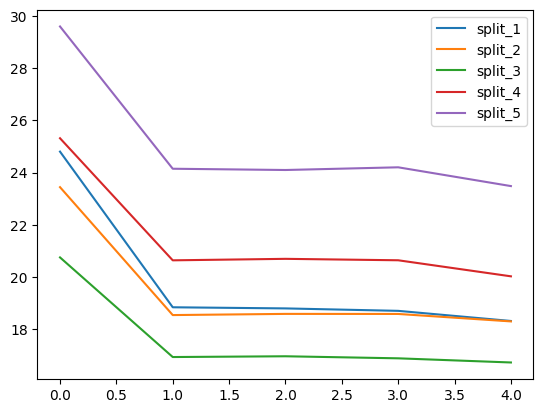

In [10]:
fig, ax = plt.subplots(dpi = 100)
for degree in range(1, quadractic_levels + 1):
    plt.plot(error_df['degrees'], error_df[f'split_{degree}'], label = f'split_{degree}')
plt.legend()

**Hence**: Using a quadractic function of the horsepower performs better than a model that involves only a linear function of the variable.

## Cross - Validation

We are going to use the [Cross_validate](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.cross_validate.html) function from the sklearn.model_selection module. It Evaluates metric(s) by cross-validation and also record fit/score times.

We are going to use a Leave-One-Out Cross Validation (LOOCV). In each iteration, we get the Mean Squared Error

In [43]:
X = Auto.loc[:, ['horsepower']]
y = Auto['mpg']
model = LinearRegression()
cv_results = cross_validate(model, X, y, cv = Auto.shape[0], scoring = 'neg_mean_squared_error')

MSE = -np.mean(cv_results['test_score'])
print(f'Using the LOOCV, our error using this linear model is: {np.round(MSE, 2)}')

Using the LOOCV, our error using this linear model is: 24.23


In [45]:
def Polynomial_Regression(data, degrees):

    poly = PolynomialFeatures(degree=degrees)
    X_poly = poly.fit_transform(data)

    return X_poly

### Using a LOOCV for quadratic levels

In [52]:
quadractic_levels = 5

cv_mse_array = np.zeros(quadractic_levels)

for idx, degree in enumerate(range(1, quadractic_levels + 1)):
    cv_results = cross_validate(model, Polynomial_Regression(X, degree), y, cv = Auto.shape[0], scoring = 'neg_mean_squared_error')
    cv_mse_array[idx] = -np.mean(cv_results['test_score'])

In [53]:
cv_mse_array

array([24.23151352, 19.24821312, 19.33498406, 19.42443031, 19.03320629])

We see a sharp drop in the estimated test MSE between the linear and quadractic fits, but no a clear improvement from using higher-degree polynomials.

### Using Kfold = 10

In [76]:
quadractic_levels = 5
cv = KFold(n_splits=10, shuffle=True, random_state=0)

cv_mse_array = np.zeros(quadractic_levels)

for idx, degree in enumerate(range(1, quadractic_levels + 1)):
    cv_results = cross_validate(model, Polynomial_Regression(X, degree), y, cv = cv, scoring = 'neg_mean_squared_error')
    cv_mse_array[idx] = -np.mean(cv_results['test_score'])

cv_mse_array

array([24.20766449, 19.18533142, 19.27626666, 19.47848402, 19.13719673])

Notice that the computation time is MUCH shorter than that of LOOCV. We still see little evidence that using cubic or higher-degree polynominal terms leads to a lower test error than simply using a quadractic fit.